# Pathway Evaluation
The goal is to analyse the behaviour of the different pathway when they are fed with the chosen substrate Methanol. They are judged by their maximum production and the maximum MA flux in relation to the biomass growth rate.

In [1]:
# Importing used packages and model
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd
import matplotlib.pyplot as plt
model = read_sbml_model('iMT1026-v3.xml')
%run -i create_pathway.ipynb
# flux unit is mmol / [gDW h]

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_oligoP_v "oligophosphate (5-P)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_polyP_v "polyphosphate (100-P)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h2o_v "H2O">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h2o_c "H2O">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ppi_c "Diphosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h_c "H+">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pi_c

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_nmn_c "Nicotinamide D-ribonucleotide">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_amp_m "AMP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_nmn_m "Nicotinamide D-ribonucleotide">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_nadp_c "NADP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_nadp_m "NADP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_nadh_m "NADH">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_nadph_m "NADPH">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_nadph_c "NADPH">
Use of FORMULA in the notes element is discouraged, use fbc:ch

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_gln_L_m "L-Glutamine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_nh4_n "Ammonium">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dnad_n "Deamino-NAD+">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h_n "H+">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ppi_n "Diphosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_amp_n "AMP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_nad_n "NAD+">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ala_L_c "L-Alanine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Spe

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_eicoscoa_x "Eicosanoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_eicos2coa_x "trans-Eicosa-2-enoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dcoscoa_x "Docosanoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dcos2coa_x "trans-Docosa-2-enoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ttccoa_x "Tetracosanoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ttc2coa_x "trans-Tetracosa-2-enoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_hexccoa_x "Hexacosanoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Speci

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pi_n "Phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_glu_L_n "L-Glutamate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cbp_n "Carbamoyl phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pser_L_c "O-Phospho-L-serine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_acser_c "O-Acetyl-L-serine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_trnaala_m "tRNA(Ala)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_amet_m "S-Adenosyl-L-methionine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ahcys_m "S-Adenosyl-L-homocysteine">
Use of F

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_1ag3p_SC_c "1-Acyl-sn-glycerol 3-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h2s_c "Hydrogen sulfide">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_so3_c "Sulfite">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_fru_c "D-Fructose">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_sbt_D_c "D-Sorbitol">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_sbt_L_c "L-Sorbitol">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_srb_L_c "L-Sorbose">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_man1p_c "D-Mannose 1-phosphate">
Use of FORMULA in the note

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_r1p_c "alpha-D-Ribose 1-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_13dpg_c "3-Phospho-D-glyceroyl phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_fdp_c "D-Fructose 1,6-bisphosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_prbatp_c "1-(5-Phosphoribosyl)-ATP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pram_c "5-Phospho-beta-D-ribosylamine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pran_c "N-(5-Phospho-D-ribosyl)anthranilate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_btn_c "Biotin">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormu

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cyst_L_x "L-Cystathionine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_nh4_x "Ammonium">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pyr_x "Pyruvate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_hcys_L_x "L-Homocysteine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_achms_c "O-Acetyl-L-homoserine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_4hbzcoa_m "4-hydroxybenzoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_4hbz_m "4-Hydroxybenzoate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_4hbz_c "4-Hydroxybenzoate">
Use of FORMULA in 

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_xu5p_D_c "D-Xylulose 5-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_damp_c "dAMP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_adn_m "Adenosine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ade_m "Adenine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_r1p_m "alpha-D-Ribose 1-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_thymd_c "Thymidine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dtmp_c "dTMP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_2dr1p_c "2-Deoxy-D-ribose 1-phosphate">
Use of FORMULA in the notes elemen

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ohpb_c "2-Oxo-3-hydroxy-4-phosphobutanoate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_2dda7p_c "2-Dehydro-3-deoxy-D-arabino-heptonate 7-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pep_m "Phosphoenolpyruvate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_e4p_m "D-Erythrose 4-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_2dda7p_m "2-Dehydro-3-deoxy-D-arabino-heptonate 7-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_s17bp_c "Sedoheptulose 1,7-bisphosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dgtp_c "dGTP">
Use of FORMULA in the notes element is d

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ggdp_c "Geranylgeranyl diphosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_f1p_c "D-Fructose 1-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_mev_R_c "(R)-Mevalonate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dad_2_c "Deoxyadenosine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dtdp_c "dTDP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dttp_c "dTTP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dump_n "dUMP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_duri_c "Deoxyuridine">
Use of FORMULA in the notes element is disc

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_Naringenin_c "Naringenin">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_Aromadendrin_c "Dihydrokaempferol">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_sph1p_c "Sphinganine 1-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pant_R_c "(R)-Pantoate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_2dhp_m "2-Dehydropantoate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pant_R_m "(R)-Pantoate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pnto_R_c "(R)-Pantothenate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_b2coa_c "Crotonoyl-CoA">
Us

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_4nph_c "4-Nitrophenol">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pan4p_m "Pantetheine 4'-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_trnaala_c "tRNA(Ala)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_alatrna_c "L-Alanyl-tRNA(Ala)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_alatrna_m "L-Alanyl-tRNA(Ala)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_leuktrA4_c "Leukotriene A4">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_leuktrB4_c "Leukotriene B4">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_2ahhmp_c "2-Amino-4-hydroxy

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_4ampm_c "4-Amino-2-methyl-5-phosphomethylpyrimidine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_2ahhmp_m "2-Amino-4-hydroxy-6-hydroxymethyl-7,8-dihydropteridine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_2ahhmd_m "2-Amino-4-hydroxy-6-hydroxymethyl-7,8-dihydropteridine diphosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dhnpt_m "Dihydroneopterin">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_gcald_m "Glycolaldehyde">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_2cpr5p_c "1-(2-Carboxyphenylamino)-1-deoxy-D-ribulose 5-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_didp_c

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_trnathr_c "tRNA(Thr)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_thrtrna_c "L-Threonyl-tRNA(Thr)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_thr_L_m "L-Threonine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_trnathr_m "tRNA(Thr)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_thrtrna_m "L-Threonyl-tRNA(Thr)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_trnatrp_c "tRNA(Trp)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_trptrna_c "L-Tryptophanyl-tRNA(Trp)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_trp_L_m "L-Tryptophan">
Use of FOR

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_mhpglu_c "5-Methyltetrahydropteroyltri-L-glutamate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_hpglu_c "Tetrahydropteroyltri-L-glutamate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_5mdru1p_c "5-Methylthio-5-deoxy-D-ribulose 1-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_2mcacn_m "(Z)-But-2-ene-1,2,3-tricarboxylate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_3hbACP_m "(3R)-3-Hydroxybutanoyl-[acyl-carrier protein]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_but2eACP_m "But-2-enoyl-[acyl-carrier protein]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_butACP_m "Butyryl-[a

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dcaACP_m "Decanoyl-ACP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_3oddecACP_m "3-Oxododecanoyl-[acp]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_3hddecACP_m "(R)-3-Hydroxydodecanoyl-[acp]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_myrsACP_m "Myristoyl-ACP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_palmACP_m "Palmitoyl-ACP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_uppg1_c "Uroporphyrinogen I">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cpppg1_c "Coproporphyrinogen I">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_2hp6mp_m

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_mpdol_c "beta-D-Mannosyldiacetylchitobiosyldiphosphodolichol">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_m1mpdol_c "alpha-D-mannosyl-beta-D-mannosyl-diacetylchitobiosyldiphosphodolichol">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_g3m8mpdol_r "(Glc)3(GlcNAc)2(Man)9(PP-Dol)1">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_g3m8masn_r "(Glc)3(GlcNAc)2(Man)9(Asn)1">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_glc_D_r "D-Glucose">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_g2m8masn_r "(Glc)2(GlcNAc)2(Man)9(Asn)1">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_g1m8masn_r "(Glc)1(GlcNAc)2(Man

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_m7masnB_r "G10694">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_15dap_c "Cadaverine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_5apal_c "5-Aminopentanal">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_hmgth_c "S-(Hydroxymethyl)glutathione">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dolmanp_g "Dolichyl phosphate D-mannose">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dolp_g "Dolichyl phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_12d3k5m_c "1,2-Dihydroxy-5-(methylthio)pent-1-en-3-one">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Speci

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_m3serthr_g "(Man)3 (Ser/Thr)1">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_25dthpp_c "2,5-diamino-6-ribitylamino-4(3H)-pyrimidinone 5'-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ctp_r "CTP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cdp_r "CDP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_34_dihydrouridine_c "3,4-dihydrouridine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ertascb_D_c "D-erythro-Ascorbate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_arab_L_c "L-Arabinose">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_a

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_4abz_m "4-Aminobenzoate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dhpt_m "Dihydropteroate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_Nfortyr_c "N-Formyl-L-tyrosine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_mnl1p_c "D-Mannitol 1-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_mnl_c "D-Mannitol">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_6dg_c "D-Gal-alpha-1->6D-Glucose">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_gam1p_c "D-Glucosamine 1-phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_alpam_m "S-aminomethy

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ipc224_SC_c "Inositol phosphorylceramide, ceramide-2 (24C), yeast-specific">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ipc226_SC_c "Inositol phosphorylceramide, ceramide-2 (26C), yeast-specific">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ipc324_SC_c "Inositol phosphorylceramide, ceramide-3 (24C), yeast-specific">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ipc326_SC_c "Inositol phosphorylceramide, ceramide-3 (26C), yeast-specific">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ipc424_SC_c "Inositol phosphorylceramide, ceramide-4 (24C), yeast-specific">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ipc426_SC_c "Inositol phosphorylceramid

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_3mbald_e "3-Methylbutanal">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_3mop_e "(S)-3-Methyl-2-oxopentanoate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_4abz_e "4-Aminobenzoate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_5aop_e "5-Aminolevulinate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_8aonn_e "8-Amino-7-oxononanoate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_abt_e "L-Arabinitol">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_4abut_e "4-Aminobutanoate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_acald_e "Acetaldehyde">
Use

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_lys_L_e "L-Lysine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_malt_e "Maltose">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_man_e "D-Mannose">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_melib_e "Melibiose">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_melib_c "Melibiose">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_met_L_e "L-Methionine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_mmet_e "S-Methyl-L-methionine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_mmet_c "S-Methyl-L-methionine">
Use of FORMULA in the notes element is discou

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_hcit_c "Homocitrate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_lald_L_m "L-Lactaldehyde">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_Lkynr_m "L-Kynurenine">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_oxag_c "Oxaloglutarate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ppa_c "Propionate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ppa_m "Propionate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ttc_ggdp_c "trasn,trans,cis-Geranylgeranyl diphosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ttc_ggdp_m "trasn,trans,cis-Geranylge

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dcos2coa_c "trans-Docosa-2-enoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ttc2coa_c "trans-Tetracosa-2-enoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_hxc2coa_c "trans-hexacosa-2-enoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_eicoscoa_c "Eicosanoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dcoscoa_c "Docosanoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_3hodcoa_c "3-Hydroxyoctadecanoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dhap_x "Dihydroxyacetone phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_POLYPPE "Endopolyhosphatase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_POLYPPE "Endopolyhosphatase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_NDP11 "nucleoside-diphosphatase (CDP)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_NDP11 "nucleoside-diphosphatase (CDP)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PHEPYRAT "L-phenylalanine:pyruvate aminotransferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PHEPYRAT "L-phenylalanine:pyruvate aminotransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds ins

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PYDXS "pyridoxal 5'-phosphate synthase (glutamine hydrolysing)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_TYRPYRAT "L-tyrosine:pyruvate aminotransferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_TYRPYRAT "L-tyrosine:pyruvate aminotransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_OPMT1 "O-linked mannosyl transferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_OPMT1 "O-linked mannosyl transferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_OPMT2 "O-linked mannosyl transferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes 

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_SBPP3er "sphingoid base-phosphate phosphatase (sphingosine 1-phosphate), endoplasmic reticulum">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_SBPP3er "sphingoid base-phosphate phosphatase (sphingosine 1-phosphate), endoplasmic reticulum">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_SGPL12 "Sphingosine phosphate lyase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_SGPL12 "Sphingosine phosphate lyase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_HXDCEALR "hexadecanal:NADP+ delta2-oxidoreductase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_HXDCEALR "hexad

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MIPCavg "Average mannose-inositol phosphorylceramide">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MIPCS424_SC "mannose-inositol phosphorylceramide synthase (ceramide-4, 24C), yeast-specific">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MIPCS424_SC "mannose-inositol phosphorylceramide synthase (ceramide-4, 24C), yeast-specific">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MIPCS426_SC "mannose-inositol phosphorylceramide synthase (ceramide-4, 26C), yeast-specific">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MIPCS426_SC "mannose-inositol phosphorylceramide synthase (ceramide-4, 26C), yeast-specific">
Encoding LOWER_BOUND

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_DPMI1246PH3 "3,5-bis(diphospho)inositol-1,2,4,6-tetrakisphosphate hydrolase (3-diphosphoinositol-1,2,4,5,6-pentakisphosphate forming)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DPMI1246PS3 "3-diphosphoinositol-1,2,4,5,6-pentakisphosphate kinase (3,5-bis(diphospho)inositol-1,2,4,6-tetrakisphosphate forming)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_DPMI1246PS3 "3-diphosphoinositol-1,2,4,5,6-pentakisphosphate kinase (3,5-bis(diphospho)inositol-1,2,4,6-tetrakisphosphate forming)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DPMI1246PH5 "3,5-bis(diphospho)inositol-1,2,4,6-tetrakisphosphate hydrolase (5-diphosphoinositol-1,2,3,4,6-pentakisphosphate forming)">
Use of GENE ASSOCIAT

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DANNt2 "7,8-Diaminononanoate reversible transport via proton symport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DCDPtn "dCDP nuclear transport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DDPAm "2-deoxy-D-arabino-heptulosonate 7-phosphate synthetase, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DESAT14 "Myristicoyl-CoA desaturase (n-C14:0CoA -> n-C14:1CoA)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DESAT18_2 "Octadecenoyl-CoA desaturase (n-C18:1CoA -> n-C18:2CoA)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_DESAT18_2 "Octadecenoyl-CoA desatur

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MELIBt2 "melibiose transport in via symport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MGSA "methylglyoxal synthase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MINOHPtn "inositol hexakisphosphate nuclear transport (diffusion)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_NABTNO "N4-Acetylaminobutanal:NAD+ oxidoreductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_NADNm "NAD nucleosidase, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_NADPPPSm "NADP phosphatase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds inste

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACOHT "Acetyl-CoA:alcohol O-acetyltransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_NFORTYRS "N-Formyl-tyrosine synthase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_COAHLm "acyl carrier Protein synthase, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PSPH1Pter "Pytosphingosine 1-phosphate transport into ER">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_SPH1Pter "sph1p transport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_2MBACt "2-methylbutyl transport (extracellular)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:flux

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FAO182p_even_odd "Fatty acid oxidation">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FAO182p_odd_odd "Fatty acid oxidation">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FAO182p_odd_odd "Fatty acid oxidation">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_OCDCYAt "Octadecynoate (n-C18:2) transport in via uniport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PAPt "PAP reversible uniport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PDE2 "3',5'-cyclic-nucleotide phosphodiesterase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, u

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_CERS224er "Ceramide-2 synthase (24C), endoplasmic reticular">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_CERS226er "Ceramide-2 synthase (26C), endoplasmic reticular">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_CERS226er "Ceramide-2 synthase (26C), endoplasmic reticular">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_IPC124PLC_PP "inositol phosphorylceramide, ceramide-1 (24C) phospholipase C">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_IPC124PLC_PP "inositol phosphorylceramide, ceramide-1 (24C) phospholipase C">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reacti

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MIP2CS224_PP "mannose-(inositol-P)2-ceramide synthase (ceramide-2, 26C), yeast specific">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MIP2CS224_PP "mannose-(inositol-P)2-ceramide synthase (ceramide-2, 26C), yeast specific">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MIP2CS226_PP "mannose-(inositol-P)2-ceramide synthase (ceramide-2, 24C), yeast-specific">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MIP2CS226_PP "mannose-(inositol-P)2-ceramide synthase (ceramide-2, 24C), yeast-specific">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MIP2CS324_PP "mannose-(inositol-P)2-ceramide synthase (ceramide-3, 24C), yeast specific">
U

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACP1e "acid phosphatase, extracellular (secreted)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACP1e "acid phosphatase, extracellular (secreted)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACRNtm "O-acetylcarnintine transport into mitochondria via diffusion">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACSm "acetyl-CoA synthetase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACSm "acetyl-CoA synthetase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACSp "acetyl-CoA synthetase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ARABR "arabinose reductase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ARABR "arabinose reductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ARGt2r "L-arganine reversible transport via proton symport">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ARGt2r "L-arganine reversible transport via proton symport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ARMT "hnRNP arginine N-methyltransferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ARMT "hnRNP arginine N-methyltransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use 

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DCYTD "deoxycytidine deaminase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_DCYTD "deoxycytidine deaminase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DCYTt2 "deoxycytidine transport in via proton symport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DESAT16 "Palmitoyl-CoA desaturase (n-C16:0CoA -> n-C16:1CoA)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_DESAT16 "Palmitoyl-CoA desaturase (n-C16:0CoA -> n-C16:1CoA)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DESAT18 "stearoyl-CoA desaturase (n-C18:0CoA -> n-C18:1CoA)">
Use of GENE ASSOCIATION or GENE_AS

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FACOAL120p "fatty-acid--CoA ligase (dodecanoate), peroxisomal">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FACOAL120p "fatty-acid--CoA ligase (dodecanoate), peroxisomal">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FACOAL140 "fatty-acid--CoA ligase (tetradecanoate)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FACOAL140 "fatty-acid--CoA ligase (tetradecanoate)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FACOAL140p "fatty-acid--CoA ligase (tetradecanoate), peroxisomal">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FACOAL140p "fatty-acid--CoA ligase (

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_G6PI "Glucose-6-phosphate isomerase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GALt2 "D-galactose transport in via proton symport">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GALt2 "D-galactose transport in via proton symport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GAM6Pt "D-glucosamine 6-phosphate reversible uniport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GCALDt "Glycoaldehydye reversible transport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GCALDtm "glycoaldehyde mitochondrial transport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_HPROb "L-hydroxyproline reductase (NADP)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_HPROb "L-hydroxyproline reductase (NADP)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_HPROxm "L-hydroxyproline dehydrogenase (NAD), mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_HPROxm "L-hydroxyproline dehydrogenase (NAD), mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_HPROym "L-hydroxyproline dehydrogenase (NADP), mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_HPROym "L-hydroxyproline dehydrogenase (NADP), mitochondrial">
E

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MEVK4 "mevalonate kinase (utp)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MEVK4 "mevalonate kinase (utp)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MHPGLUT "5-methyltetrahydropteroyltriglutamate-homocysteine S-methyltransferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MHPGLUT "5-methyltetrahydropteroyltriglutamate-homocysteine S-methyltransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MI1345PKn "inositol-1,3,4,5-triphosphate 6-kinase, nucleus">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MI1345PKn "inositol-1,3,4,5-triphosphate 6-kin

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_OXAGm "non-enzymatic reaction">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_OXO2Ctm "2-oxodicarboylate transporter, mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_OXO2Ctm "2-oxodicarboylate transporter, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_P5CR "pyrroline-5-carboxylate reductase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_P5CR "pyrroline-5-carboxylate reductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PANTtm "pantothenate mitochondrial transport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, us

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PYDXO "pyridoxal oxidase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PYDXO "pyridoxal oxidase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PYR5CDm "D1-pyrroline-5-carboxylate dehydrogenase, mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PYR5CDm "D1-pyrroline-5-carboxylate dehydrogenase, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PYRt2 "pyruvate transport in via proton symport">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PYRt2 "pyruvate transport in via proton symport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLa

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_THMt2 "Thiamine transport in via proton symport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_THRA2i "L-allo-Threonine Aldolase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_THRA2i "L-allo-Threonine Aldolase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_THRD_Lm "L-threonine deaminase, mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_THRD_Lm "L-threonine deaminase, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_THRt2r "L-threonine reversible transport via proton symport">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes 

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_TYRTAim "tyrosine transaminase, irreversible (mitochondrial)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_TYRTAim "tyrosine transaminase, irreversible (mitochondrial)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_TYRTAip "tyrosine transaminase, irreversible (peroxisomal)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_TYRTAip "tyrosine transaminase, irreversible (peroxisomal)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FTHFLmi "formate-tetrahydrofolate ligase, mitochondrial irreversible">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FTHFLmi "formate-t

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACHLE2 "Isobutyl acetate-hydrolyzing esterase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACHLE3 "Ethyl acetate-hydrolyzing esterase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACHLE3 "Ethyl acetate-hydrolyzing esterase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ALCD22xi "aldehyde dehydrogenase (2-methylbutanol, NAD)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ALCD22xi "aldehyde dehydrogenase (2-methylbutanol, NAD)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ALCD22xim "aldehyde dehydrogenase (2-methylbutanol, NAD), mitochondrial">
Use of GE

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_LPP_PP "lipid phosphate phosphatase, yeast-specific">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_LPP_PP "lipid phosphate phosphatase, yeast-specific">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MI13456PKn "inositol-1,3,4,5,6-pentakisphosphate 2-kinase, nuclear">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MI13456PKn "inositol-1,3,4,5,6-pentakisphosphate 2-kinase, nuclear">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PI35BP5P_PP "1-phosphatidylinositol-3,5-bisphosphate 5-phosphatase, yeast-specific">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PI35BP

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_NADPt "NADP transporter">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_NFORTYRt "N,N-bisformyl-dityrosine transport (extracellular)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_NFORTYRt "N,N-bisformyl-dityrosine transport (extracellular)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_NH4ti "ammonia transport (efflux, cytosol to extracellular)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_NH4ti "ammonia transport (efflux, cytosol to extracellular)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_OAAt "Oxaloacetate transport">
Encoding LOWER_BOUND and UPPER_BOUND 

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GLUt7 "L-glutamate transport out via proton symport, vacuolar">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ILEt6 "L-isoleucine transport in via proton antiport (vacuolar)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ILEt6 "L-isoleucine transport in via proton antiport (vacuolar)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_LEUt6 "L-leucine transport in via proton antiport (vacuolar)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_LEUt6 "L-leucine transport in via proton antiport (vacuolar)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_TCHOLAabcv "Tau

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_3OAR160m "3-oxoacyl-[acyl-carrier-protein] reductase (n-C16:0)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_3OAR180m "3-oxoacyl-[acyl-carrier-protein] reductase (n-C18:0)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_3OAR180m "3-oxoacyl-[acyl-carrier-protein] reductase (n-C18:0)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_3OAR40m "3-oxoacyl-[acyl-carrier-protein] reductase (n-C4:0)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_3OAR40m "3-oxoacyl-[acyl-carrier-protein] reductase (n-C4:0)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_3OAR60m "3-oxoac

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACODA "acetylornithine deacetylase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACONTx "aconitase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACPpds "[acyl-carrier-protein] phosphodiesterase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACPS1 "acyl-carrier protein synthase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACPS1 "acyl-carrier protein synthase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ADPRDP "ADPribose diphosphatase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ADPRDP "AD

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_DESAT18_10 "Octadecatrienoyl-CoA desaturase (n-C18:2CoA -> n-C18:3CoA)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DHAD1 "dihydroxy-acid dehydratase (2,3-dihydroxy-3-methylbutanoate)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_DHAD1 "dihydroxy-acid dehydratase (2,3-dihydroxy-3-methylbutanoate)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DHAD2 "Dihydroxy-acid dehydratase (2,3-dihydroxy-3-methylpentanoate)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DHPPDA2 "diaminohydroxyphosphoribosylaminopryrimidine deaminase (25drapp)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gp

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ETFQO "Electron transfer flavoprotein-ubiquinone oxidoreductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FACOAE160 "fatty-acid-CoA thioesterase (hexadecanoate)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FACOAE160 "fatty-acid-CoA thioesterase (hexadecanoate)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FACOAE180 "fatty-acid-CoA thioesterase (octadecanoate)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FACOAE180 "fatty-acid-CoA thioesterase (octadecanoate)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FACOAL180 "fatty-acid--CoA ligase (octadeca

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GPDDA2 "Glycerophosphodiester phosphodiesterase (Glycerophosphoethanolamine)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GPDDA2 "Glycerophosphodiester phosphodiesterase (Glycerophosphoethanolamine)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GPIMTer "Phosphatidylinositol glycan">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GPIMTer "Phosphatidylinositol glycan">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GTHRDHpp "glutathione hydralase (periplasmic)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GTHRDHpp "glutathione hydralase (periplasmic)">
Encod

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_LFORKYNHYD "L-Formylkynurenine hydrolase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_LPASE "lysophospholipase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_LPASE "lysophospholipase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_lplipa2 "Lysophospholipase L (acyl-glycerophosphoethanolamine)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_lplipa2 "Lysophospholipase L (acyl-glycerophosphoethanolamine)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_LTA4H "Leukotriene A-4 hydrolase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discour

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MMTSAO "(S)-Methylmalonate semialdehyde:NAD+ oxidoreductase (CoA-propanoylating)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MTAN "methylthioadenosine nucleosidase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MTRK "5-methylthioribose kinase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_NADDP "NAD diphosphatase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_NADDP "NAD diphosphatase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_NADDPm "NAD diphosphatase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_SERTRSm "Seryl-tRNA synthetase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_SERTRSm "Seryl-tRNA synthetase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_SPMDOX "Spermidine:(acceptor) oxidoreductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_SPODM "superoxide dismutase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_SPODM "superoxide dismutase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_SPODMm "superoxide dismutase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_SPODMm "superoxide dismuta

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACOAO04p "Butanoyl-CoA:oxygen 2-oxidoreductase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACOAO04p "Butanoyl-CoA:oxygen 2-oxidoreductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACOAO06p "Hexanoyl-CoA:(acceptor) 2,3-oxidoreductase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACOAO06p "Hexanoyl-CoA:(acceptor) 2,3-oxidoreductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACOAO08p "Octanoyl-CoA:oxygen 2-oxidoreductase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACOAO08p "Octanoyl-CoA:oxygen 2-oxidoreductase">
Encoding LOWER_BOUND and UPPER_

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ICDOXSUCm "Isocitrate:NADP+ oxidoreductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_2OXOADOX "2-oxoadipate dehydrogenase complex">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_2OXOADOX "2-oxoadipate dehydrogenase complex">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PGH "Phosphatidylglycerol cholinephosphohydrolase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PGH "Phosphatidylglycerol cholinephosphohydrolase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PETH "Phosphatidylethanolamine phosphatidohydrolase">
Use of GENE ASSOCIATION or GENE_ASSOCIAT

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PTPPALDHT "2-Acetolactate pyruvate-lyase (carboxylating)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PTPPALDHT "2-Acetolactate pyruvate-lyase (carboxylating)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MCPSULT "3-Mercaptopyruvate:cyanide sulfurtransferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MCPSULT "3-Mercaptopyruvate:cyanide sulfurtransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ARDENDR "cis-3,4-leucopelargonidin:NADP+ 4-oxidoreductase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ARDENDR "cis-3,4-leucopelargonidin:NADP+ 4-oxid

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DHDPP "Farnesyl diphosphate:Isopentenyl diphosphate farnesyl cistransferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_DHDPP "Farnesyl diphosphate:Isopentenyl diphosphate farnesyl cistransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GPIAT "glucosaminylphosphatidyl inositol acetyltransferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GPIAT "glucosaminylphosphatidyl inositol acetyltransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_CERASE224 "Ceramidase (cer2_24)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_CERASE224 "Ceramidase (ce

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_IND3ACS "Transferases">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_16MANASE "alpha-mannosidase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_16MANASE "alpha-mannosidase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_AGPGAT "acyl-CoA:1-acyl-sn-glycero-3-phosphoglycerol O-acyltransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_AGPGS "1-acyl-sn-glycero-3-phosphoglycerol O-acyltransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MLCLPNAT "monolysocardiolipin acyltransferase ">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, u

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_HOMtm "L-homoserine mitochondrial permease">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_OROTtm "orotate mitochondrial permease">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_METtm "L-methionine mitochondrial permease">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_METtm "L-methionine mitochondrial permease">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_TRPtm "L-tryptophan transport">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_TRPtm "L-tryptophan transport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FA260COAabcp "peroxisomal transport of hexacosanoyl-CoA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DHAtv "Dihydroxyacetone transport via facilitated diffusion">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GTPGDPtv "GDP-GTP transport into vacuole">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MANtv "Mannose transport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GTPtv "GTP transport into vacuole via diffusion">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DHAPtv "Dihydroxyacetone phosphotransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACACT9p "acetyl-CoA acyltransferase (tetracosanoyl-CoA), peroxisomal">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACACT9p "acetyl-CoA acyltransferase (tetracosanoyl-CoA), peroxisomal">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACOAO9p "acyl-CoA oxidase (hexacanoyl-CoA), peroxisomal">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACOAO9p "acyl-CoA oxidase (hexacanoyl-CoA), peroxisomal">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_CERS124 "Ceramide-1 synthase (24C)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_CERS124 "Ceramide-1 synthase (24C)">
Encod

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ABUTDm "Aminobutyraldehyde dehydrogenase, mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ABUTDm "Aminobutyraldehyde dehydrogenase, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACACT1 "acetyl-CoA C-acetyltransferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACACT1 "acetyl-CoA C-acetyltransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACACT4p "acetyl-CoA C-acetyltransferase (octanoyl-CoA), peroxisomal">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ACACT4p "acetyl-CoA C-acetyltransferase (octanoyl-CoA), peroxisomal">

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ADCL "4-aminobenzoate synthase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ADCS "4-amino-4-deoxychorismate synthase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ADCS "4-amino-4-deoxychorismate synthase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ADK1m "adenylate kinase, mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ADK1m "adenylate kinase, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ADMDC "adenosylmethionine decarboxylase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr i

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ALLTNr "allantoinase, reversible reaction">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ALLTNti "allantoin irreversible uniport">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ALLTNti "allantoin irreversible uniport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ALPHNH "allophanate hydrolase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ALPHNH "allophanate hydrolase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_AMETtm "S-Adenosyl-L-methionine reversible transport, mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discour

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ATPM "ATP maintenance requirement">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ATPPRT "ATP phosphoribosyltransferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ATPPRT "ATP phosphoribosyltransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ATPS3m "ATP synthase, mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ATPS3m "ATP synthase, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ATPS3v "ATP synthase, vacuole">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ATPS3v

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_CO2tv "CO2 vacuolar transport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_CPPPGO "coproporphyrinogen oxidase (O2 required)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_CPPPGO "coproporphyrinogen oxidase (O2 required)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_CRNCARtm "carnithine-acetylcarnithine carrier, mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_CRNCARtm "carnithine-acetylcarnithine carrier, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_CSm "citrate synthase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes ele

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_DHAD1m "dihydroxy-acid dehydratase (2,3-dihydroxy-3-methylbutanoate), mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DHAD2m "dihydroxy-acid dehydratase (2,3-dihydroxy-3-methylpentanoate), mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_DHAD2m "dihydroxy-acid dehydratase (2,3-dihydroxy-3-methylpentanoate), mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DHAK "Dihydroxyacetone kinase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_DHAK "Dihydroxyacetone kinase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DHAPtm "dihyd

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ECOAH8p "3-hydroxyacyl-CoA dehydratase (3-hydroxyoctadecanoyl-CoA), peroxisomal">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EHGLAT "L-erythro-4-Hydroxyglutamate:2-oxoglutarate aminotransferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_EHGLAT "L-erythro-4-Hydroxyglutamate:2-oxoglutarate aminotransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ENO "enolase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ENO "enolase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ETHAK "Ethanolamine kinase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the not

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FORt "formate transport via diffusion">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FRTT "farnesyltranstransferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FRTT "farnesyltranstransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FTHFCL "5-formethyltetrahydrofolate cyclo-ligase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FTHFCL "5-formethyltetrahydrofolate cyclo-ligase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FTHFLi "formate-tetrahydrofolate ligase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr i

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GLCS2 "glycogen synthase (UDPGlc)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GLCtv "glucose transport, vacuolar">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GLNS "glutamine synthetase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GLNS "glutamine synthetase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GLNTRS "Glutaminyl-tRNA synthetase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GLNTRS "Glutaminyl-tRNA synthetase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GLPT "glycylpeptide N-tet

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GUAD "guanine deaminase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GUAD "guanine deaminase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GUAPRT "guanine phosphoribosyltransferase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GUAPRT "guanine phosphoribosyltransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_H2Ot "H2O transport via diffusion">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_H2Ot "H2O transport via diffusion">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_H2Otm "H2O transpo

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_HPROa "L-hydroxyproline reductase (NAD)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_HPROa "L-hydroxyproline reductase (NAD)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_HSDxi "homoserine dehydrogenase (NADH), irreversible">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_HSDxi "homoserine dehydrogenase (NADH), irreversible">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_HSDyi "homoserine dehydrogenase (NADP), irreversible">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_HSDyi "homoserine dehydrogenase (NADP), irreversible">
Encoding LOWER_BOUND and UPPER_BO

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_LEUTRS "Leucyl-tRNA synthetase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_LEUTRSm "leucyl-tRNA synthetase, mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_LEUTRSm "leucyl-tRNA synthetase, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_LNS14DM "cytochrome P450 lanosterol 14-alpha-demethylase (NADP)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_LNS14DM "cytochrome P450 lanosterol 14-alpha-demethylase (NADP)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_LNSTLS "lanosterol synthase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION 

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MTHFD2i "methylenetetrahydrofolate dehydrogenase (NAD)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MTHFDm "methylenetetrahydrofolate dehydrogenase (NADP), mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MTHFDm "methylenetetrahydrofolate dehydrogenase (NADP), mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MTHFR3 "5,10-methylenetetrahydrofolatereductase (NADPH)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MTHFR3 "5,10-methylenetetrahydrofolatereductase (NADPH)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MTRI "5-methylthiori

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_NTD4 "5'-nucleotidase (CMP)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_NTRLASE "nitrilase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_NTRLASE "nitrilase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_O2t "o2 transport (diffusion)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_O2tm "O2 transport (diffusion)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_OAAt2m "oxaloacetate transport, mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_OAAt2m "oxaloacetate transport, mitochondrial

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PHCDm "L-1-pyrroline-3-hydroxy-5-carboxylate dehydrogenase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PHETA1 "phenylalanine transaminase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PHETA1 "phenylalanine transaminase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PHETRS "Phenylalanyl-tRNA synthetase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PHETRS "Phenylalanyl-tRNA synthetase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PHETRSm "phenylalanyl-tRNA synthetase, mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is d

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PRAMPC "phosphoribosyl-AMP cyclohydrolase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PRASCS "phosphoribosylaminoimidazolesuccinocarboxamide synthase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PRASCS "phosphoribosylaminoimidazolesuccinocarboxamide synthase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PRATPP "phosphoribosyl-ATP pyrophosphatase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PRATPP "phosphoribosyl-ATP pyrophosphatase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PRFGS "phosphoribosylformylglycinamidine synthase">
Use of GENE ASSOCIA

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_RNDR2 "ribonucleoside-diphosphate reductase (GDP)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_RNDR3 "ribonucleoside-diphosphate reductase (CDP)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_RNDR3 "ribonucleoside-diphosphate reductase (CDP)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_RNDR4 "ribonucleoside-diphosphate reductase (UDP)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_RNDR4 "ribonucleoside-diphosphate reductase (UDP)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_RPE "ribulose 5-phosphate 3-epimerase">
Use of GENE ASSOCIATION or GENE_ASSOC

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_SUCCtm "succinate transport, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_SUCD1m "succinate dehydrogenase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_SUCD1m "succinate dehydrogenase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_SUCD3_u6m "succinate dehydrogenase (ubiquinone-6), mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_SUCD3_u6m "succinate dehydrogenase (ubiquinone-6), mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_SUCFUMtm "succinate-fumarate transport, mitochondrial">
Use of GENE ASSOCIATION or GENE_AS

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_TRPS1 "tryptophan synthase (indoleglycerol phosphate)">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_TRPS1 "tryptophan synthase (indoleglycerol phosphate)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_TRPTRS "Tryptophanyl-tRNA synthetase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_TRPTRS "Tryptophanyl-tRNA synthetase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_TRPTRSm "Tryptophanyl-tRNA synthetase, mitochondrial">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_TRPTRSm "Tryptophanyl-tRNA synthetase, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND 

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MCITL2m "methylisocitrate lyase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_MCITL2m "methylisocitrate lyase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_AOD "Alcohol oxidase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_AOD "Alcohol oxidase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_UTPH1 "UTP diphosphohydrolase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_UTPH1 "UTP diphosphohydrolase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ACCOACrm "Acetyl-Coa carboxylase, mitochondrial">
Us

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ERGSTGLCT "UDP-glucose:ergosterol glucosyltransferase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EPISTESTH_PP "episterol ester hydrolase, yeast-specific">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_EPISTESTH_PP "episterol ester hydrolase, yeast-specific">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ERGSTESTH_PP "ergosterol ester hydrolase, yeast-specific">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ERGSTESTH_PP "ergosterol ester hydrolase, yeast-specific">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FECOSTESTH_PP "fecosterol ester hydrolase, yeas

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GTPt2m "GTP/GDP translocase, mitochondrial (electroneutral)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_2OBUTtm "2obut transporter (mitochondrial)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ALAtmi "Alanine transport from mitochondia to cytoplasm">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ALAtmi "Alanine transport from mitochondia to cytoplasm">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_2PHETOHtm "2-phenylethanol reversible transport, mitochondrial">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PStm_PP "phosphatidylserine mitochondrial  transport, ye

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_asp_L "L-Aspartate exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_fmn "FMN exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_pi "Phosphate exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_ribflv "Riboflavin exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_thmpp "Thiamine diphosphate exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_h "H+ exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_thm "Thiamine exchange">
Encoding LOWER_BOUND and UPPER_BOUND in Kine

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_abt "L-Arabinitol exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_4abut "4-Aminobutanoate exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_acald "Acetaldehyde exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_aces "ethylacetate exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_ACP "acyl carrier protein exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_ade "Adenine exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_adn "Adenosine exchange">
Encoding LOWER_BOU

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_k "potassium exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_leu_L "L-Leucine exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_lac_L "L-Lactate exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_lys_L "L-Lysine exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_malt "Maltose exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_man "D-Mannose exchange">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Ex_melib "Melibiose exchange">
Encoding LOWER_BOUND and UPPER_BOUND in Kine

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_RBK_D "D-ribulokinase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_DABTDEH "D-arabitol dehydrogenase (D-ribulose-forming)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_Htr "H+ transport to ER">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FAS1_4 "Acetyl-[acyl-carrier-protein]:malonyl-[acyl-carrier-protein]">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FAS1_4 "Acetyl-[acyl-carrier-protein]:malonyl-[acyl-carrier-protein]">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FAS1_6 "butyryl-[acyl-carrier protein]:malonyl-[acyl-carrier-protein]">
Use of GENE ASSOCIATION or GEN

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FAS3_14 "(3R)-3-Hydroxymiristoyl-[acyl-carrier-protein] hydro-lyase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FAS3_16 "(3R)-3-Hydroxypalmitoyl-[acyl-carrier-protein] hydro-lyase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FAS3_16 "(3R)-3-Hydroxypalmitoyl-[acyl-carrier-protein] hydro-lyase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FAS3_18 "(3R)-3-hydroxystearoyl ACP dehydrase ">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FAS3_18 "(3R)-3-hydroxystearoyl ACP dehydrase ">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FAS4_4 "Butyryl-[acyl-carrier

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FAE2_22 "3-Docosanoyl-CoA reductase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FAE2_22 "3-Docosanoyl-CoA reductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FAE2_24 "3-tetracosanoyl-CoA reductase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FAE2_24 "3-tetracosanoyl-CoA reductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FAE2_26 "3-hexacosanoyl-CoA reductase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FAE2_26 "3-hexacosanoyl-CoA reductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Rea

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FA200COAabcp "peroxisomal transport of eicosanoyl-CoA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FA220COAabcp "peroxisomal transport of docosanoyl-CoA">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FA220COAabcp "peroxisomal transport of docosanoyl-CoA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_H2Otg "Water transport into golgi">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_RMNt "L-rhamnose transport">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_RMNDH "L-rhamnose dehydrogenase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discourag

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DAGL_PP "Diacylglycerol acyl-hydrolase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_M4MPDOLter "(GlcNAc)2(Man)5(PP-Dol)1 Transport, ER">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_M7MASNBterg "m7masnB transport from endoplasmic reticulum to Golgi apparatus">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MANter "mannose efflux from endoplasmic reticulum">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MIPCS124_SC "mannose-inositiol phophorylceramide synthase (ceramide-1, 24C), yeast-specific">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MIPCS126_SC "mannose-inositol phosphorylceramide synthase

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FACOAL180p "fatty-acid--CoA ligase (octadecanoate)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FACOAL181p "fatty-acid--CoA ligase (octadecenoate)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FACOAL182p "fatty-acid--CoA ligase (octadecynoate)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FACOAL183p "fatty-acid--CoA ligase (octadecatrienoate)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FACOAL240 "fatty-acid--CoA ligase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PTE141x "peroxisomal acyl-CoA thioesterase (C14:1)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fl

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CHITINtg "Chitin transport, Golgi">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MANNANtg "Mannan transport into Golgi">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FARCOAtm "Average fatty acyl-CoA transport into mitochondria">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FACOAtm "Average fatty acid transport into mitochondria">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CLPNtm "Cardiolipin transport to cytosol for phospholipid composition">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DEDOLPP "Dehydrodolichol-PP phosphatase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use 

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ADEtm "adenine reversible transport, mitochondria">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AHMMPS "4-amino-5-hydroxymethyl-2-methylpyrimidine synthetase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AKGt2n "2-oxoglutarate nuclear transport via proton symport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AKGtp "AKG transporter, peroxisome">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AOBUTDs "L-2-amino-3-oxobutanoate decarboxylation (spontaneous)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_APRTO2 "N-acetylputrescine: oxygen oxireductase (deaminating)">
Encoding OBJECTIVE_COEFFICIENT 

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GSNK "guanosine kinase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GSNtm "guanosine facilated transport in mitochondria">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GUAtm "guanine mitochondrial transport via diffusion">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_H2O2tn "hydrogen peroxide nuclear transport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HCYSt2p "Homocysteine peroxisomal transport via proton symport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HYPOE "hypothetical enyme">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction 

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_SPMDAT1 "Spermidine acetyltransferase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_SUCRt2 "sucrose transport in via proton symport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TMDK1 "thymidine kinase (ATP:thymidine)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TMN "thiaminase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MPK "thiamine-phosphate kinase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TREHv "alpha,alpha-trehalase (vacuolar)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TRPt2m "tryptophan mitochondrial transport via 

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_SBTD_D2 "D-sorbitol dehydrogenase (D-fructose producing)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_SBTD_L "L-sorbitol dehydrogenase (L-sorbose-producing)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_SBTR "D-sorbitol reductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PDXPHT "pyridoxal phosphatase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_E4PDH "erythrose-4-phosphate dehydrogenase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EPISTESTH_Ppe "episterol ester hydrolase, yeast-specific (extracellular)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObject

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MIP2CS326_PP "mannose-(inositol-P)2-ceramide synthase (ceramide-3, 26C), yeast-specific">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MIPC124PLC_PP "Mannose-inositol phosphorylceramide, ceramide-1 (24C) phospholipase C">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MIPC126PLC_PP "Mannose-inositol phosphorylceramide, ceramide-1 (26C) phospholipase C">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MIPC224PLC_PP "Mannose-inositol phosphorylceramide, ceramide-2 (24C) phospholipase C">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MIPC226PLC_PP "Mannose-inositol phosphorylceramide, ceramide-2 (26C) phospholipase C">
Encoding OBJECTIVE_COEFFICIENT in KineticL

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AMID "amidase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AMID2 "amidase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AMPN "AMP nucleosidase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ARAB_Lt "L-arabinoase extracellular transport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ARABR "arabinose reductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ARGt2r "L-arganine reversible transport via proton symport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ARMT "hnRNP arginine N-methyltransferase">
Encoding OBJECTIVE_COEFFICIENT in

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DXHPScm "deoxyhypusine synthase, cytosolic/mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EHGLATm "L-erythro-4-Hydroxyglutamate:2-oxoglutarate aminotransferase, mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EHGLATp "L-erythro-4-Hydroxyglutamate:2-oxoglutarate aminotransferase, peroxisomal">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ERGSTt "ergosterol reversible transport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ERGSTter "Ergosterol transport, ER">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ERGTETROLter "Ergosta-5,6,22,24,(28)-tetraen-3beta-ol endoplamic r

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GTHP "glutathione peridoxase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GTHRDt2 "glutathione transport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GTMLT "g-glutamyltransferase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GUAt2r "guanine reversible transport via proton symport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_H2Oter "H2O endoplasmic reticulum transport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_H2Otn "H2O transport, nuclear">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HCITSn "homocitrate synthase">
Encoding O

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_NADH2_u6cm "NADH dehydrogenase, cytosolic/mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_NADH2_u6m "NADH dehydrogenase, mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_NAt3_1 "sodium proton antiporter (H:NA is 1:1)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_NDP1 "nucleoside-diphosphatase (ADP)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_NDP3g "nucleoside-diphosphatase (GDP), Golgi">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_NDPK9 "nucleoside-diphosphate kinase (ATP:IDP)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective inst

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_RNDR3n "ribonucleoside-diphosphate reductase (CDP), nuclear">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_RNDR4n "ribonucleoside-diphosphate reductase (UDP), nuclear">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_RNMK "ribosylnicotinamide kinase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_RNTR1 "ribonucleoside-triphosphate reductase (ATP)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_RNTR2 "ribonucleoside-triphosphate reductase (GTP)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_RNTR3 "ribonucleoside-triphosphate reductase (CTP)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discourage

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GLYCDy "Glycerol dehydrogenase (NADP-dependent)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_VALTAim "valine transaminase, mitochondiral">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DASYNm_PP "CDP-Diacylglycerol synthetase, yeast-specific, mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PSERSm_PP "phosphatidylserine synthase, yeast-specific, mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DHORDfum "Fumarate dependent DHORD">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_BTDD_RR "(R,R)-butanediol dehydrogenase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discour

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PIN4Kn_PP "phosphatidylinositol 4-kinase, nuclear, yeast-specifc">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PMI12346PS "5-diphosphoinositol-1,2,3,4,6-pentakisphosphate synthase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PMI1346PS "diphosphoinositol-1,3,4,6-tetrakisphosphate synthase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HEMEOMOm "Heme O monooxygenase, mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PYRDC2 "pyruvate decarboxylase (acetoin-forming)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_SBPP2er "sphingoid base-phosphate phosphatase (phytosphingosine 1-phospha

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_IND3ETHtm "Tryptophol transport (mitochondrial)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_IPDPtm "Isopentenyl diphosphate transport, mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PACALDtm "Phenylacetaldehyde transport (mitochondrial)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PENDPtm "all-trans-Pentaprenyl diphosphate transport, mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GLUt7m "Glutamate transport (uniporter), mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_THMPPt2m "Thiamine diphosphate transport, mitochondria">
Encoding OBJECTIVE_COEFFIC

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_3SALATAi "3-sulfino-alanine transaminase (irreversible)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_3SPYRSP "3-sulfinopyruvate hydrolase (spotaneous reaction)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_5HOXINDACTO2OX "5-Hydroxyindoleacetaldehyde:oxygen oxidoreductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_5HOXINDACTOX "5-Hydroxyindoleacetaldehyde:NAD+ oxidoreductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_5MTHFtm "5-Methyltetrahydrofolate mitochondrial transport via diffusion">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AACOAT "Acetoacetyl-CoA:acetate CoA-transferase">
E

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DOLASNT "STT">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DOLPGT1 "ALG6">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DOLPGT2 "ALG8">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DOLPGT3 "ALG10">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DOLPHer "dolichyl-phosphate phosphohydrolase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DOLPMT1 "ALG3">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DOLPMT2 "ALG9">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DOLPMT3 "ALG12">
Encoding

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GPDDA2 "Glycerophosphodiester phosphodiesterase (Glycerophosphoethanolamine)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GPIMTer "Phosphatidylinositol glycan">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GTHRDHpp "glutathione hydralase (periplasmic)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GUACYC "guanylate cyclase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_H2ETer "H2 phosphoethanolaminyl transferase, endoplasmic reticulum">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_H5MTer "Phosphatidylinositol glycan">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxOb

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MM8Ber "mannosyl-oligosaccharide 1,2-alpha-mannosidase, endoplasmic reticulum">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MMSAD3 "methylmalonate-semialdehyde dehydrogenase (malonic semialdehyde)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MMTSAO "(S)-Methylmalonate semialdehyde:NAD+ oxidoreductase (CoA-propanoylating)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MTAN "methylthioadenosine nucleosidase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MTRK "5-methylthioribose kinase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_NADDP "NAD diphosphatase">
Encoding OBJECTIVE_COEFFICIENT in Ki

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_3HBCOAHLm "3-hydroxyisobutyryl-CoA hydrolase, mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GLNFRDOX "L-glutamate:ferredoxin oxidoreductase (transaminating)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FCYTB5R "NADH:ferricytochrome-b5 oxidoreductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_NADHKm "ATP:NADH 2'-phosphotransferase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_OSUCCCL "oxalosuccinate carboxy-lyase (2-oxoglutarate-forming)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_OSUCCCLm "oxalosuccinate carboxy-lyase (2-oxoglutarate-forming)">
Encoding OBJECTIVE_COEFFI

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PDHbrm "pyruvate dehydrogenase (dihydrolipoamide) reversible">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GALURUT "UTP:1-Phospho-alpha-D-galacturonate uridylyltransferase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_3OASTO "3-Oxo-5alpha-steroid:(acceptor) delta4-oxidoreductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_3M2OBLOXRD3 "3-Methyl-2-oxobutanoate:lipoamide oxidoreductase(decarboxylating and acceptor-2-methylpropanoylating)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ECOAH9p "(S)-3-Hydroxyeicosanoyl-CoA hydro-lyase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ECOAH10p "(S)-

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DKMPPDb "1,2-dihydroxy-5-(methylthio)pent-1-en-3-one:oxygen oxidoreductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DKMPPDa "5-(methylthio)-2,3-dioxopentyl-phosphate phosphohydrolase (isomerizing)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CITMALS "D-citramalate synthase ">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CYSST "cysteine synthase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_4MOPDH1 "3-methyl-2-oxobutanoate dehydrogenase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_4MOPDH2 "3-methyl-2-oxobutanoate dehydrogenase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discoura

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_growth "Growth ">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_L_LACt "(S)-Lactate permease">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PIt2g "Orthophosphate golgi transport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ATPtg_H "ADP-ATP golgi transport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GTHOXtm "Glutathione disulfide Mitochondrial permease">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_H2Stm "h2s transport (diffusion)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_NCAMtm "Nicotinamine Mitochondrial permease">
Encoding OB

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_34HPPOR "4-Hydroxyphenylpyruvate:oxygen oxidoreductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ASPGLUtp "aspartate-glutamate peroxisomal shuttle">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CO2tg "CO2 Golgi transport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CRNCARtp "carnitine-acetylcarnitine carrier, peroxisomal">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DHFtm "dihydrofolate reversible mitochondrial transport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FLDO "NAD(P)H-flavin oxidoreductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective 

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CDPDGPm_PP "CDP-diacylglycerol--serine O-phosphatidyltransferae, yeast-specific, mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_13BGH "Endo-1,3-beta-glucan glucohydrase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_13GS "1,3-beta-glucan synthase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_2DHPtm "2-Dehydropantoate mitochondrial transport">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_3C3HMPtm "2-Isopropylmalate transport, diffusion, mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_3DSPHR "3-Dehydrosphinganine reductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AHCYStm "S-adenosyl-L-homocysteine reversible transport, mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AICART "phosphoribosylaminoimidazolecarboxamide formyltransferase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AIRCr "phosphoribosylaminoimidazole carboxylase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AKGDbm "oxoglutarate dehydrogenase (dihydrolipoamide S-succinyltransferase)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_AKP1 "alkaline phosphatase (Dihydroneopterin)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ALASm "5-aminolevulinate synthase">
Encoding OBJECTIVE_COEF

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_C8STI "C-8 sterol isomerase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CATp "catalase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CBPS "carbamoyl-phosphate synthase (glutamine-hydrolysing)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CHLPCTD "choline phosphate cytididyltransferase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CHOLK "Choline kinase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CHORM "chorismate mutase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CHORS "chorismate synthase">
Encoding OBJECTIVE_COEFFICIENT in 

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DPCOAK "dephospho-CoA kinase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DPMVD "diphosphomevalonate decarboxylase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DPR "2-dehydropantoate 2-reductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DTMPK "dTMP kinase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DURIPP "deoxyuridine phosphorylase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DUTPDP "dUTP diphosphatase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ECOAH11p "3-hydroxyacyl-CoA dehydratase (3-hydroxyhexacosyl-CoA), peroxiso

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GARFTi "phosphoribosylglycinamide formyltransferase, irreversible">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GAT2_PP "glycerol 3-phosphate acyltransferase (glycerone phosphate), yeast-specific">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GCCam "glycine-cleavage complex (lipoylprotein), mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GCCbim "glycine-cleavage complex (lipoylprotein) irreversible, mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GCCcm "glycine-cleavage complex (lipoylprotein), mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GF6PTA "gluta

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HETZK "hydroxyethylthiazole kinase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HEX1 "hexokinase (D-glucose:ATP)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HEX4 "hexokinase (D-mannose:ATP)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HEX7 "hexokinase (D-fructose:ATP)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HISTP "histidinol-phosphatase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HISTRS "Histidyl-tRNA synthetase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HISTRSm "histidyl-tRNA synthetase, mitochondrial">
Encoding OB

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MDHp "malate dehydrogenase, peroxisomal">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MDRPD "5-Methylthio-5-deoxy-D-ribulose 1-phosphate dehydratase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ME1m "malic enzyme (NAD), mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_METAT "methionine adenosyltransferase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_METS "methionine synthase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_METTRS "Methionyl-tRNA synthetase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_METTRSm "methionyl-

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PDHcm "pyruvate dehydrogenase (dihydrolipoamide dehydrogenase)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PETHCT "phosphoethanolamine cytidyltransferase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PETOHM_PP "phosphatidylethanolamine N-methyltransferase, yeast-specific">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PFK "phosphofructokinase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PFK26 "6-phosphofructo-2-kinase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PGCD "phosphoglycerate dehydrogenase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective inste

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PUNP3 "purine-nucleoside phosphorylase (Guanosine)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PUNP4 "purine-nucleoside phosphorylase (Deoxyguanosine)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PUNP5 "purine-nucleoside phosphorylase (Inosine)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PUNP6 "purine-nucleoside phosphorylase (Deoxyinosine)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PYK "pyruvate kinase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PYRDC "pyruvate decarboxylase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TMDPK "thiamine diphosphokinase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TMDS "thymidylate synthase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TMPPP "thiamine-phosphate diphosphorylase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TPI "triose-phosphate isomerase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TRDR "thioredoxin reductase (NADPH)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TRE6PP "trehalose-phosphatase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TRE6PS "alpha,alpha-trehalose-phosphate synthase (UDP-forming

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_LANOSTAT_PP "Acyl-CoA:lanosterol acyltransferase, yeast-specific">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ZYMSTAT_PP "Acyl-CoA:zymosterol acyltransferase, yeast-specific">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ZYMSTESTH_PP "zymosterol ester hydrolase, yeast-specific">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DASYN_PP "CDP-Diacylglycerol synthetase, yeast-specific">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PSERS_PP "phosphatidylserine synthase, yeast-specific">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PSERDg_PP "phosphatidylserine decarboxylase, yeast-specific, Golgi">
E

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TYRt6 "L-tyrosine transport in via proton antiport (vacuolar)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TYRt7 "L-tyrosine transport out via proton symport, vacuolar">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GLCNtv "Glycogen vacuolar 'transport' via autophagy">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ARGt6 "L-arginine transport in via proton antiport (vacuolar)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ASNt7 "L-asparagine transport out via proton symport, vacuolar">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ASPt7 "L-aspartate transport out via proton symport, vacuolar">
En

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_for "Formate exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_pyr "Pyruvate exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_2hb "2-Hydroxybutyrate exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_2mbac "2-methylbutyl acetate exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_2mbald "2-Methylbutanal exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_2mbtoh "2-methyl-1-butanol exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_2mppal "2-methylpropanal exchange">
Encoding OBJECTIVE_

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_hdca "Hexadecanoate exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_hdcea "Hexadecenoate exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_his_L "L-Histidine exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_hxan "Hypoxanthine exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_iamac "Isoamyl acetate exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_iamoh "Isoamyl alcohol exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_ibutac "isobutyl acetate exchange">
Encoding OBJECTIVE_COEFF

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_xyl_D "D-Xylose exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_xylt "Xylitol exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_pectin "Pectin exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_galur "D-Galacturonate exchange">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_NADPH2_u6cm "NADPH dehydrogenase, cytosolic/mitochondrial">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_D_ABTt "D-arabinitol transport via passive diffusion">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_Ex_abt_D "D-Arabitol exchange">
E

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FAE1_20 "Stearoyl-CoA:malonyl-CoA C-acyltransferase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FAE1_22 "Eicosanoyl-CoA:malonyl-CoA C-acyltransferase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FAE1_24 "Docosanoyl-CoA:malonyl-CoA C-acyltransferase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FAE1_26 "tetracosanoyl-CoA:malonyl-CoA C-acyltransferase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FAE2_14 "3-tetradecanoyl-CoA reductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FAE2_16 "3-hexadecanoyl-CoA reductase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:f

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TKT2x "transketolase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FBA3x "Sedoheptulose 1,7-bisphosphate D-glyceraldehyde-3-phosphate-lyase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_SHBPH "Sedoheptulose bisphosphatase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_TKT1x "transketolase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_RPIx "ribose-5-phosphate isomerase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_RPEx "ribulose 5-phosphate 3-epimerase">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_DHAPtx "Dihydroxyacetone phosphate 

In [2]:
# path_selector legend
# 0 -> no additional reactions
#1 -> beta alanine pathway  
#2 -> transferase malonyl-CoA pathway  
#3 -> oxidoreuctive malonyl-CoA pathway
#4 -> lactate pathway  
#create_pathway(model,3)  # self-built function create_pathway(model, path_selector), that adds pathway

#factor_growth = 0.5
beta_model = create_pathway(model.copy(),1)
trn_malonyl_model = create_pathway(model.copy(),2)
red_malonyl_model = create_pathway(model.copy(),3)
lactate_model = create_pathway(model.copy(),4)
# saving all the models in a list made up of tuples with their name, in order to use them in loops later. This reduces the necessary code in the  evaluation.
models = [(beta_model,'Beta-Alanine'),(trn_malonyl_model,'Malonyl-CoA Transferase'),(red_malonyl_model,'Malonyl-CoA Oxidored'),(lactate_model,'Lactate')]

Added beta alanine pathway
Added trans malonyl-CoA pathway
Added red malonyl-CoA pathway
Added lactate pathway


### Medium for evaluation
The medium is set once and used for all the evaluation of the pathways to gurantee comparable results. The carbon source is changed from the model default of glycerol to methanol. The methanol uptake flux is set to a realistic value from cf.Tomàs‐Gamisans 2018.

In [3]:
# General medium for all models based on the unchanged vanilla model (=same medium as in all derived models)
medium = model.medium
medium['Ex_meoh'] = 6  # 6 = Realistic methanol uptake rates cf.Tomàs‐Gamisans 2018
medium['Ex_glyc'] = 0

## Simulating pathways and visualizing results
The pathways are one by one simulated with the set medium flux. They are analyzed for maximum malonic acid production in relation to the biomass growth. The phenotypic phase planes show the relation of the carbon yield for malonic acid on methanol as a function of the growth rate.

General maximum biomass growth 0.09511188654246659


,Beta-Alanine,Malonyl-CoA Transferase,Malonyl-CoA Oxidored,Lactate
max carbon yield,1.0,1.0,0.982837,0.881316
max production,2.0,2.0,1.965673,1.762632


Text(0, 0.5, 'Carbon yield MA / Substrate')

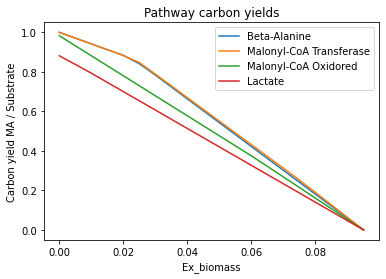

In [4]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope
import pandas as pd

model.medium = medium
model.objective = model.reactions.get_by_id('Ex_biomass')

df_yields = pd.DataFrame()
df_max = pd.DataFrame(index=['max carbon yield','max production'])
max_growth = model.slim_optimize()
print('General maximum biomass growth',max_growth)

for pairing in models:
    pathway_model = pairing[0]
    with pathway_model:
        pathway_model.medium = medium
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
        ppp = production_envelope(pathway_model,
                    reactions='Ex_biomass',
                    objective='Ex_mln')
        df_yields[pairing[1]]=ppp.carbon_yield_maximum
        #print(ppp.carbon_yield_maximum.max())
        df_max[pairing[1]]=[ppp.carbon_yield_maximum.max(),ppp.flux_maximum.max()]
        #ppp.plot(x='Ex_biomass', y=['flux_maximum', 'carbon_yield_maximum'], title=pairing[1])

display(df_max)
df_yields['Ex_biomass'] = ppp.Ex_biomass
df_yields.plot(x='Ex_biomass', y=[pairing[1] for pairing in models], title='Pathway carbon yields').set_ylabel('Carbon yield MA / Substrate')


### Discussion
The graph shows the relation of the carbon yield of malonic acid per substrate (Cmol MA / Cmol MeOH) as a function of the biomass growth rate. The provided table furthermore gives the maximum values for all pathways as well as the maximum productivity. Those values are only theoretical possible, because they are optimized for zero growth rate, which would lead to a dying organism colony.  
The results show, that first of all the maximum yield of malonic acid is the highest for the beta-alanine and malonyl-CoA Transerase pathway. Also the phenotypic phase plane shows a better behaviour in the curvature. For the first two pathways, a smaller reduction over the increasing biomass growth rate is visible, before having a crack in the curvture and going down to the maximum growth rate with no malonic acid production.  
The results show that the first two pathways are preferable for malonic acid production and are further examined for strain improvements.

# Evaluating optimal O2 uptake
The 2 most promising pathways, beta-alanine and malonyl-coa, are further analysed for their O2 uptake. Since the supply with oxygen is often a limiting factor in fermentations, the information of optimal O2 uptake for the different objectives, growth and malonic acid production, is of great value.

In [5]:
# Defining new models variable, to only look at the 2 more efficient pathways
models2 = [models[0],models[1]]
# Initializing a dictionary and a dataframe to collect the calculated values from the loops
cons_factor = 0.5  # factor of biomass growth for the constrained model
o2_uptake = dict()
df_values = pd.DataFrame(index=['MA production','biomass growth', 'MA constrained'])  # creating a dataframe for the maximum valeus with a predefined index to display them later
# To save codelines, a loop over the interesting pathways is created, as seen before in the other evaluations
for pairing in models2:
    pathway_model = pairing[0]
    df_pathway = pd.DataFrame()  # a data frame that collects the simulation results for the current pathway
    with pathway_model:
        pathway_model.medium = medium  # setting the medium (as before)
        # Obtaining values for malonic acid production
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
        ppp = production_envelope(pathway_model,      # a phentopyic phase plane evaluation for the O2 uptake of the current pathway
                    reactions='Ex_o2',
                    objective='Ex_mln')
        df_pathway['MA production']=ppp.flux_maximum  # saving values for the MA prod in the dataframe
        df_pathway['Ex_o2 MA'] = ppp.Ex_o2
        mln = (round(ppp.Ex_o2[ppp.flux_maximum.idxmax()],3),round(ppp.flux_maximum.max(),3))   # saving the maximum O2 uptake rate for MA of the current pathway
        
        # Obtaining values for biomass growth, same procedure as MA but different objective function
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_biomass')
        ppp = production_envelope(pathway_model,
                    reactions='Ex_o2',
                    objective='Ex_biomass')
        df_pathway['20xBiomass']=ppp.flux_maximum*20   # saving values for the biomass growth in a dataframe, multiplying them by 20 to make them more visible in the graph
        df_pathway['Ex_o2 bio'] = ppp.Ex_o2  # Adding the O2 values of the simulation for the x-axis for the plot
        bio = (round(ppp.Ex_o2[ppp.flux_maximum.idxmax()],3), round(ppp.flux_maximum.max(),3))
        max_growth = ppp.flux_maximum.max()
        
        # Obtaining values for constrained biomass growth, same procedure as MA but different objective function
        constrained_growth = pathway_model.problem.Constraint(
            pathway_model.reactions.Ex_biomass.flux_expression,
            lb=max_growth*cons_factor)
        pathway_model.add_cons_vars(constrained_growth)
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
        ppp = production_envelope(pathway_model,
                    reactions='Ex_o2',
                    objective='Ex_mln')
        df_pathway['MA constrained']=ppp.flux_maximum  # saving values for the biomass growth in a dataframe, multiplying them by 20 to make them more visible in the graph
        df_pathway['Ex_o2 MA cons'] = ppp.Ex_o2        # Adding the meoh values of the simulation for the x-axis for the plot
        ma_cons = (round(ppp.Ex_o2[ppp.flux_maximum.idxmax()],3),round(ppp.flux_maximum.max(),3))

        # carrying all the obtained results out of the loop and with environment by saving them in a data frame or dictionary with the pathway name as key
        df_values[pairing[1]] = [mln,bio,ma_cons]  # saving the o2 uptake rate at the maximum production/growth as a list
        o2_uptake[pairing[1]] = df_pathway

print('Optimum O2 uptake & production/growth at that point')
display(df_values)               

Optimum O2 uptake & production/growth at that point


,Beta-Alanine,Malonyl-CoA Transferase
MA production,"(-5.094, 1.953)","(-5.094, 1.953)"
biomass growth,"(-5.528, 0.093)","(-5.528, 0.093)"
MA constrained,"(-5.132, 1.107)","(-4.911, 1.139)"


Text(0, 0.5, 'max flux')

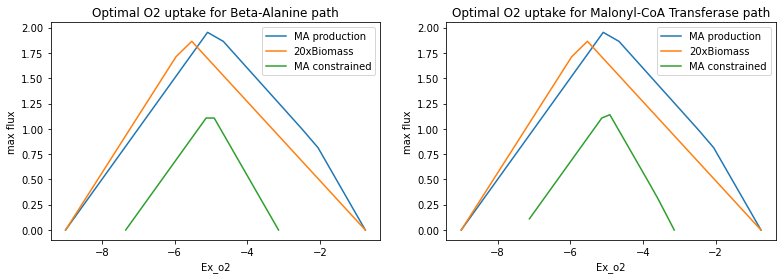

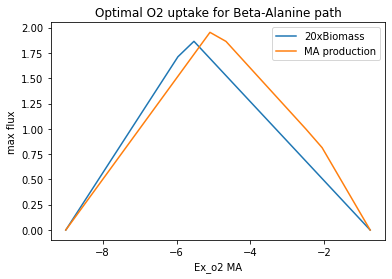

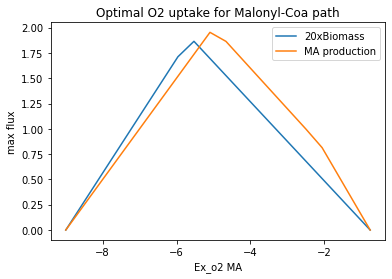

In [6]:
# Plotting the results
# Plot style 1
num_models = len(o2_uptake.keys())  # save the number of pathways analyzed for meoh production
fig, ax = plt.subplots(1, 2, sharey = False) # creating a subplot of the dimension 1x2
fig.set_figwidth(13)  # increasing readability by setting width
#fig.set_figheight(10)
for num in range(num_models):   # creating a loop that uses a range to index over all models contained in meOh uptake to match each subplot field with a model
    # ax[num].rcParams['figure.figsize'] = [10, 4]
    ax[num].plot(o2_uptake[models[num][1]]['Ex_o2 MA'], o2_uptake[models[num][1]]['MA production'], label='MA production')   # plotting the MA Production for the respeective model
    ax[num].plot(o2_uptake[models[num][1]]['Ex_o2 bio'], o2_uptake[models[num][1]]['20xBiomass'], label='20xBiomass')   # plotting the biomass growth for the respeective model
    ax[num].plot(o2_uptake[models[num][1]]['Ex_o2 MA cons'], o2_uptake[models[num][1]]['MA constrained'], label='MA constrained')   # plotting the biomass growth for the respeective model
    # setting the correct labels and title and shwoing the legend for the subplots
    ax[num].set_ylabel('max flux')
    ax[num].set_xlabel('Ex_o2')
    ax[num].set_title('Optimal O2 uptake for '+models[num][1]+' path')
    ax[num].legend()
# Plot style 2
o2_uptake[models[0][1]].plot(x='Ex_o2 MA', y=['20xBiomass', 'MA production'], title='Optimal O2 uptake for Beta-Alanine path').set_ylabel('max flux')
o2_uptake[models[1][1]].plot(x='Ex_o2 MA', y=['20xBiomass', 'MA production'], title='Optimal O2 uptake for Malonyl-Coa path').set_ylabel('max flux')
# For theoretical additional evaluation of the other pathways (have to set models2 to models again)
#o2_uptake[models[2][1]].plot(x='Ex_o2', y=['20xBiomass', 'MA production'], title='Optimal O2 uptake for Malonyl-Coa2 path').set_ylabel('max flux')
#o2_uptake[models[3][1]].plot(x='Ex_o2', y=['20xBiomass', 'MA production'], title='Optimal O2 uptake for lactate path').set_ylabel('max flux')

### Discussion
The results for the two pathways for the oxygen dependency are equal. Both the malonic acid production and the biomass growth rate seem to have the same oxygen dependency for both pathways.  
Interestingly the oxygen demand varys between the two objectives malonic acid producation and biomass growth. The optimal uptake is slightly higher for the biomass growth. Also a difference in the curvature is visible. Furthermore a constrained simulation has been conducted where the growth was set to 50% of the maximum growth on 6 mmol/gDW\*h methanol and no oxygen limitation. Under this boundary conditions, malonic acid is only produced after an O2 uptake rate of >~ 3 mmol/gDW\*h and reaches less production, because of the parallel growth. The peak of maximum production is shifted and a slight difference between the two pathways is noted.  
  
It can be seen that the malonic acid and the biomass are having influence on the optimum and the optimal uptake rate has to be determined for a previoulsy fixed or targeted biomass growth rate.

# Ideal maximum methanol uptake
Analyse for the theoretically best methanol concentration for both growth an malonic acid production

In [7]:
# Definin new medium with high meoh concentration to see the behaviour over a wide range of uptake rates
medium2 = model.medium
medium2['Ex_meoh'] = 1000  # 6 = Realistic methanol uptake rates cf.Tomàs‐Gamisans 2018
medium2['Ex_glyc'] = 0

In [8]:
# Using the same code as for the O2 uptake evaluation but supstituting the reaction of the ppp production_envelope from O2 to MeOH
# Defining new models variable, to only look at the 2 more efficient pathways
models2 = [models[0],models[1]]
# Initializing a dictionary and a dataframe to collect the calculated values from the loops
meoh_uptake = dict()
df_values = pd.DataFrame(index=['MA production','biomass growth'])  # creating a dataframe for the maximum valeus with a predefined index to display them later
# To save codelines, a loop over the interesting pathways is created, as seen before in the other evaluations
for pairing in models2:
    pathway_model = pairing[0]
    df_pathway = pd.DataFrame()  # a data frame that collects the simulation results for the current pathway
    with pathway_model:
        pathway_model.medium = medium2  # setting the medium (as before)
        # Obtaining values for malonic acid production
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
        ppp = production_envelope(pathway_model,      # a phentopyic phase plane evaluation for the meoh uptake of the current pathway
                    reactions='Ex_meoh',
                    objective='Ex_mln')
        df_pathway['MA production']=ppp.flux_maximum  # saving values for the MA prod in the dataframe
        df_pathway['Ex_meoh MA'] = ppp.Ex_meoh
        mln=ppp.Ex_meoh[ppp.flux_maximum.idxmax()]   # saving the maximum meoh uptake rate for MA of the current pathway

        # Obtaining values for biomass growth, same procedure as MA but different objective function
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_biomass')
        ppp = production_envelope(pathway_model,
                    reactions='Ex_meoh',
                    objective='Ex_biomass')
        df_pathway['20xBiomass']=ppp.flux_maximum*20   # saving values for the biomass growth in a dataframe, multiplying them by 20 to make them more visible in the graph
        df_pathway['Ex_meoh bio'] = ppp.Ex_meoh
        bio = ppp.Ex_meoh[ppp.flux_maximum.idxmax()]
       
        # carrying all the obtained results out of the loop and with environment by saving them in a data frame or dictionary with the pathway name as key
        df_values[pairing[1]] = [mln,bio]  # saving the meoh uptake rate at the maximum production/growth as a list
        meoh_uptake[pairing[1]] = df_pathway
        #display(df_pathway)

print('Optimum MeOH uptake in mmol/(gDW*h)')
display(df_values)

Optimum MeOH uptake in mmol/(gDW*h)


,Beta-Alanine,Malonyl-CoA Transferase
MA production,-742.79005,-742.79005
biomass growth,-594.33244,-594.33244


Text(0, 0.5, 'max flux')

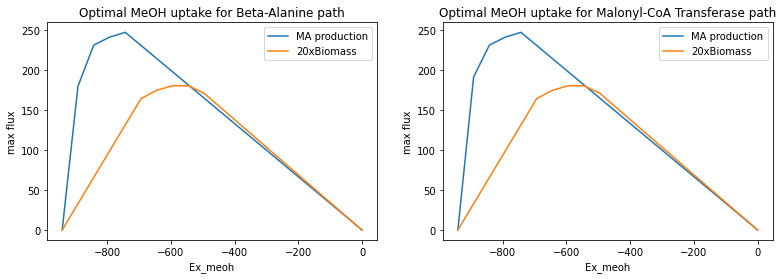

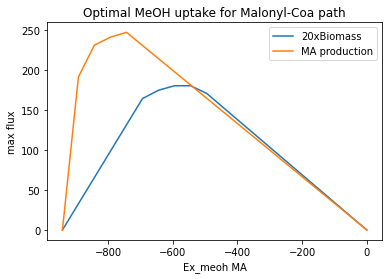

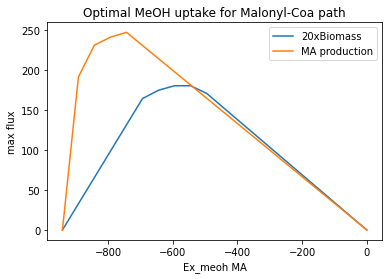

In [9]:
# Plotting the results
# Plot style 1
num_models = len(meoh_uptake.keys())  # save the number of pathways analyzed for meoh production
fig, ax = plt.subplots(1, 2, sharey = False) # creating a subplot of the dimension 1x2
fig.set_figwidth(13)  # increasing readability by setting width

for num in range(num_models):   # creating a loop that uses a range to index over all models contained in meOh uptake to match each subplot field with a model
    # ax[num].rcParams['figure.figsize'] = [10, 4]
    ax[num].plot(meoh_uptake[models[num][1]]['Ex_meoh MA'], meoh_uptake[models[num][1]]['MA production'], label='MA production')   # plotting the MA Production for the respeective model
    ax[num].plot(meoh_uptake[models[num][1]]['Ex_meoh bio'], meoh_uptake[models[num][1]]['20xBiomass'], label='20xBiomass')   # plotting the biomass growth for the respeective model
    # setting the correct labels and title and shwoing the legend for the subplots
    ax[num].set_ylabel('max flux')
    ax[num].set_xlabel('Ex_meoh')
    ax[num].set_title('Optimal MeOH uptake for '+models[num][1]+' path')
    ax[num].legend()
# Plot style 2
meoh_uptake[models[1][1]].plot(x='Ex_meoh MA', y=['20xBiomass', 'MA production'], title='Optimal MeOH uptake for Malonyl-Coa path').set_ylabel('max flux')
meoh_uptake[models[1][1]].plot(x='Ex_meoh MA', y=['20xBiomass', 'MA production'], title='Optimal MeOH uptake for Malonyl-Coa path').set_ylabel('max flux')
# For theoretical additional evaluation of the other pathways (have to set models2 to models again)
# meoh_uptake[models[2][1]].plot(x='Ex_meoh', y=['20xBiomass', 'MA production'], title='Optimal MeOH uptake for Malonyl-Coa2 path').set_ylabel('max flux')
# meoh_uptake[models[3][1]].plot(x='Ex_meoh', y=['20xBiomass', 'MA production'], title='Optimal MeOH uptake for lactate path').set_ylabel('max flux')

### Discussion
The results show that also here both pathways have the same dynamics for both objectives, malonic acid producation and biomass growth. It is noted, theat the maximum flux of malonic acid production is at a higher uptake rate than biomass growth. The graphs compare both fluxes, but the growth rate was multiplied with a factor of 20 to put the fluxes in the same range as the ones of the malonic acid growth. This means that the differences are much smaller than they look for the growth rate. It can be seen, that the malonic acid flux is about a third of the methanol uptake rate until the maximum is reached. This is the same relation as for the amount of carbon atoms between the two molecules.  
  
It is interesting to see that a carbon source repression seems to happen after the maximum is reached. The exact reason for this phenomena is not clear, since no other substrate is limiting the production. The repressions seems to be stronger for the growth rate than for the malonic acid production. Furthermore, the production and growth rate doesnt level off, but decrease back to zero eventually, which would mean that the cells die at to high methanol uptake fluxes.  
  
Furthermore it has to be noted, that the physically possible upatake rates are at very small values. CITATION found an uptake rate of 6 mmol/gDW\*h, which was also used for most of the evaluations. Therefore the repression through methanol is outside of a reachable uptake rate and poses no concern for the derived phenotypes. But the evaluation shows, that a linear increase of production can be achieved through an upregulation of the methanol uptake capabilities.

# Evaluating for minimal medium
In this section the minimal fluxes to achieve the specified growth or malonic acid production are obtained.  This way the medium is analysed for essential components and their quantative uptake, in order to identify possible limiting factors.

In [10]:
from cobra.medium import minimal_medium
print(medium)


{'Ex_h2o': 1000.0, 'Ex_nh4': 1000.0, 'Ex_pi': 1000.0, 'Ex_h': 1000.0, 'Ex_o2': 1000.0, 'Ex_so4': 1000.0, 'Ex_glyc': 0, 'Ex_fe2': 1000.0, 'Ex_btn': 4e-05, 'Ex_k': 1000.0, 'Ex_meoh': 6}


### Analyzing for biomass growth
The medium is anaylsed for essential components for the biomass growth.

In [14]:
# for biomass growth
df_med_bio = pd.DataFrame()   # creating data frame for better visualization

for pairing in models2:
    pathway_model = pairing[0]
    with pathway_model:
        pathway_model.medium = medium  # setting medium for model
        max_growth = pathway_model.slim_optimize()
        min_med=minimal_medium(pathway_model, max_growth)  # evaluating the minimal medium to achive the biomass growth in the model
        min_med['biomass growth'] = max_growth  # saving the growth in the same data series
        df_med_bio[pairing[1]+' bio'] = min_med   # saving the generated result in the data frame under the pathway name
        
#display(df_med_bio)

### Analyzing for malonic acid production
The medium is anaylsed for essential components for the production of malonic acid.

In [15]:
# for malonic acid production growth
df_med_mln = pd.DataFrame()

for pairing in models2:
    pathway_model = pairing[0]
    with pathway_model:
        pathway_model.medium = medium
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
        max_production = pathway_model.slim_optimize()
        min_med = minimal_medium(pathway_model, max_production)
        min_med['MA production'] = max_production
        df_med_mln[pairing[1]+' MA'] = min_med
        
#display(df_med_mln)

,Ex_nh4,Ex_pi,Ex_o2,Ex_so4,Ex_meoh,biomass growth,MA production
Beta-Alanine bio,0.590011,0.023928,5.623948,0.004172,6.0,0.095112,NaN
Malonyl-CoA Transferase bio,0.590011,0.023928,5.623947,0.004172,6.0,0.095112,NaN
Beta-Alanine MA,NaN,NaN,5.000000,NaN,6.0,NaN,2.0
Malonyl-CoA Transferase MA,NaN,NaN,5.000000,NaN,6.0,NaN,2.0


<AxesSubplot:>

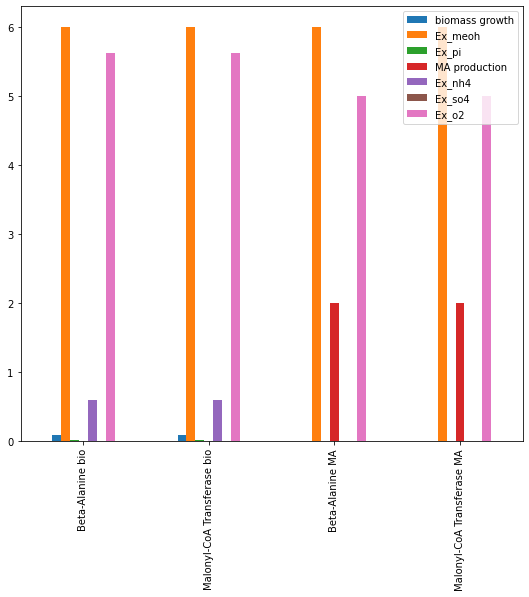

In [16]:
transpose=pd.concat([df_med_bio.T, df_med_mln.T])
display(transpose)
arguments = list(set(list(df_med_bio.index) + list(df_med_mln.index)))
#arguments = ['Ex_o2', 'Ex_nh4', 'Ex_pi', 'Ex_so4']
transpose.plot(y= arguments, kind='bar', figsize=(9,8))

### Discussion
As seen in the results, the medium only needs a few components to ensure the growth and production. In general the substrate is the limitation in both cases. Further it has to be noticed, that the demands to the medium are much lower for the malonic acid production, which theoretically only needs the carbon source and oxygen to work.  
Nevertheless, it has to be noted, that several compounds are deemed as unnecessary which has to be seen critical. First and foremost the complex additive Biotin doesnt seem to effect the growth or malic acid production in any way, while it is known to be vital to yeast organisms.